In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LassoLarsCV, LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_squared_error

from tmpnn import Regression
from dnnr import DNNR

data: https://archive.ics.uci.edu/dataset/243/yacht+hydrodynamics

In [3]:
columns = ['lcg', 'cp', 'volume', 'b/d', 'l/b', 'fn', 'r',]
df = pd.read_csv('yacht_hydrodynamics.data', sep=' ', encoding='utf-8', names=columns)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308 entries, 0 to 307
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lcg     308 non-null    float64
 1   cp      308 non-null    float64
 2   volume  308 non-null    float64
 3   b/d     308 non-null    float64
 4   l/b     308 non-null    float64
 5   fn      308 non-null    float64
 6   r       308 non-null    float64
dtypes: float64(7)
memory usage: 17.0 KB


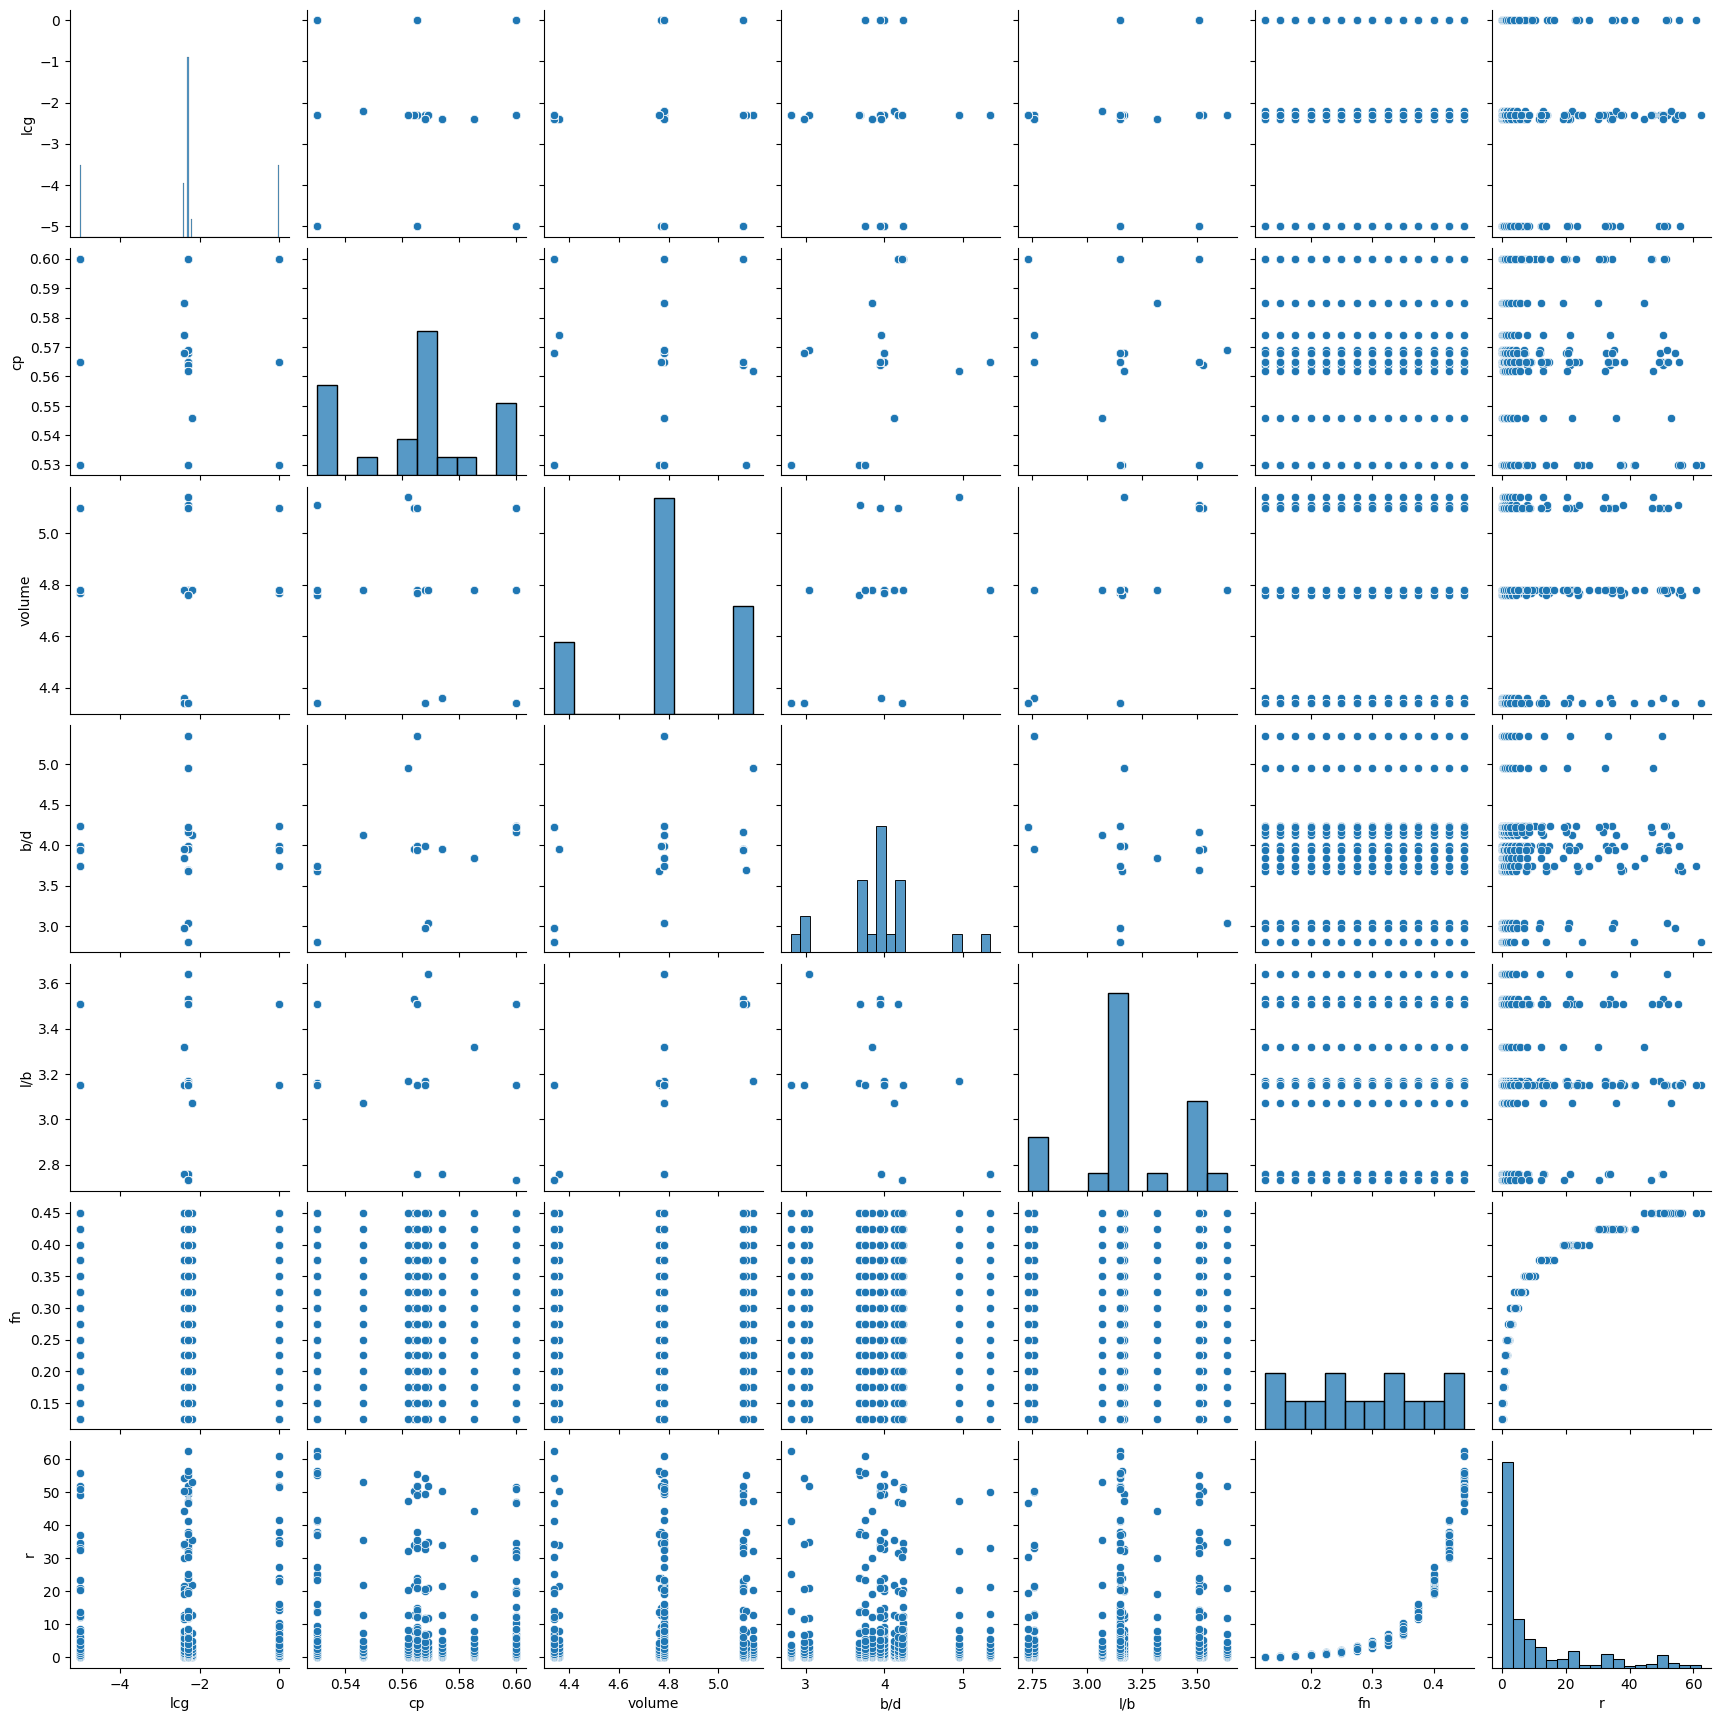

In [ ]:
sns.pairplot(df)

In [4]:
X, Y = df.iloc[:,:-1], df.iloc[:,-1]
test = X['fn']>0.375
X_train, X_test = X[~test], X[test]
Y_train, Y_test = Y[~test], Y[test]
print(f"test {(Y_test.size/Y.size*100):.0f}%")

test 21%


In [5]:
def score(model):
    print(f"mse train: {mean_squared_error(Y_train, model.predict(X_train.values))}")
    print(f"mse test: {mean_squared_error(Y_test, model.predict(X_test.values))}")

In [7]:
model = CatBoostRegressor(random_state=0,iterations=1000)
model.fit(X_train,Y_train,eval_set=(X_test,Y_test),verbose=0)
score(model)

mse train: 0.0001629931358003467
mse test: 693.8573784361162


In [29]:
model = DNNR(2,2)
model.fit(X_train.values, Y_train.values)
score(model)

mse train: 0.17348347107437967
mse test: 357.05696780303026


In [16]:
ss = MinMaxScaler((0,0.2))
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)
model = Regression(num_features=X.columns.size, num_targets=1, order=2, steps=7, learning_rate=0.01, is_scale=False)
model.fit(X_train, Y_train, epochs=1000, verbose=0)
score(model)

mse train: 0.10124883927467067
mse test: 22.97966424494907


In [18]:
meta = {}
for name, flag in df.describe().loc['75%'].items():
    test = df[name]>flag

    X_train, X_test = X[~test], X[test]
    Y_train, Y_test = Y[~test], Y[test]

    index = name+' > '+f'{flag:.3f}'+' '+str(int(Y_test.size/Y.size*100))+'%'
    row = []

    # model = CatBoostRegressor(random_state=0,iterations=1000)
    # model.fit(X_train,Y_train,eval_set=(X_test,Y_test),verbose=0)
    # row.append(r2_score(Y_train,model.predict(X_train)))
    # row.append(r2_score(Y_test,model.predict(X_test)))

    # model = Pipeline(steps=[
    #     ('scaler', StandardScaler()),
    #     ('poly', PolynomialFeatures(degree=4, include_bias=False)),
    #     ('estimator', LassoLarsCV())
    # ])
    model = DNNR(2,2,order='2')
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)
    X_test = ss.transform(X_test)
    model.fit(X_train, Y_train.values)
    row.append(r2_score(Y_train,model.predict(X_train)))
    row.append(r2_score(Y_test,model.predict(X_test)))

    # ss = MinMaxScaler()
    # X_train = ss.fit_transform(X_train)
    # X_test = ss.transform(X_test)
    # model = Regression(num_features=X.columns.size, num_targets=1, order=4, steps=1)
    # model.set_learning_rate(1e-3)
    # model.fit(X_train, Y_train, epochs=5000, verbose=0)
    # row.append(r2_score(Y_train,model.predict(X_train)))
    # row.append(r2_score(Y_test,model.predict(X_test)))

    meta[index]=row    

In [19]:
dmeta = pd.DataFrame(data=meta).transpose()
dmeta.columns = pd.MultiIndex.from_tuples(
    [('DNNR(2,2)','train'),('DNNR(2,2)','test')],
    names=['model','split'])
indexs = dmeta.index.tolist()
indexs = list(map(lambda x: x.replace('>',' > '), indexs))
dmeta.index = indexs
dmeta

model               DNNR(2,2)          
split                   train      test
lcg  >  -2.300 22%   0.996842  0.972568
cp  >  0.574 22%     0.997976  0.993073
volume  >  5.100 9%  0.997909  0.984619
b/d  >  4.170 22%    0.997193  0.995034
l/b  >  3.510 9%     0.998381  0.995329
fn  >  0.375 21%     0.991274 -0.709953
r  >  12.815 25%     0.989966 -0.590431